## 文本相似度实例

## Step1 导入相关包

In [15]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset

## Step2 加载数据集

In [16]:
dataset = load_dataset("json", data_files="./train_pair_1w.json", split="train")
dataset

Dataset({
    features: ['sentence1', 'sentence2', 'label'],
    num_rows: 10000
})

In [17]:
dataset[0]

{'sentence1': '找一部小时候的动画片', 'sentence2': '求一部小时候的动画片。谢了', 'label': '1'}

## Step3 划分数据集

In [18]:
datasets = dataset.train_test_split(test_size=0.2)
datasets

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label'],
        num_rows: 8000
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label'],
        num_rows: 2000
    })
})

## Step4 数据集预处理

In [19]:
import torch

tokenizer = AutoTokenizer.from_pretrained("hfl/chinese-macbert-base")

def process_function(examples):
    sentences=[]
    labels=[]
    # 遍历examples中的数据
    for sen1,sen2,label in zip(examples["sentence1"],examples["sentence2"],examples["label"]):
        sentences.append(sen1)
        sentences.append(sen2)
        labels.append(1 if int(label)==1 else -1)
    tokenized_examples = tokenizer(sentences,max_length=128, truncation=True,padding="max_length")
    # 组成一对一对的
    # input_ids ,attention_mask,token_type_ids,label
    tokenized_examples={k:[v[i:i+2] for i in range(0,len(v),2)] for k,v in tokenized_examples.items()}
    tokenized_examples["labels"] = [float(label) for label in examples["label"]]
    return tokenized_examples

tokenized_datasets = datasets.map(process_function, batched=True, remove_columns=datasets["train"].column_names)
tokenized_datasets

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 8000
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 2000
    })
})

In [20]:
print(tokenized_datasets['train'][0])
print(tokenized_datasets['train'].column_names)

{'input_ids': [[101, 1762, 6929, 7027, 8024, 800, 6878, 1168, 2110, 3413, 7027, 4638, 5439, 1398, 2110, 5101, 1894, 1217, 1469, 823, 1127, 511, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 872, 812, 4638, 4135, 7410, 3221, 3918, 7028, 4638, 8024, 852, 3221, 4640, 2370, 7363, 678, 1469, 1744, 4374, 2199, 6206, 3867, 7370, 6821, 763, 4135, 7410, 511, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

## Step5 创建模型

In [21]:
from transformers import BertForSequenceClassification, BertPreTrainedModel, BertModel
from typing import Optional
from transformers.configuration_utils import PretrainedConfig
from torch.nn import CosineSimilarity, CosineEmbeddingLoss
import torch.nn as nn


model = AutoModelForSequenceClassification.from_pretrained("hfl/chinese-macbert-base", num_labels=1)


class DualModel(BertPreTrainedModel):
    def __init__(self, config:PretrainedConfig,*inputs,**kwargs):
        super().__init__(config,*inputs,**kwargs)
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, 1)
        self.init_weights()
    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        token_type_ids: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
        # **kwargs,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        # Step1分别获取sentenceA和sentenceB的输入
        senA_input_ids,senB_input_ids=input_ids[:0],input_ids[:1]
        senA_attention_mask,senB_attention_mask=attention_mask[:0],attention_mask[:1]
        senA_token_type_ids,senB_token_type_ids=token_type_ids[:0],token_type_ids[:1]

        # Step2 分别获取sentenceA和sentenceB的向量表示
        senA_outputs = self.bert(
            senA_input_ids,
            attention_mask=senA_attention_mask,
            token_type_ids=senA_token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        senA_pooled_output = senA_outputs[1]   # 数据格式 [batch,hidden]


        senB_outputs = self.bert(
            senB_input_ids,
            attention_mask=senB_attention_mask,
            token_type_ids=senB_token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        senB_pooled_output = senB_outputs[1]   # 数据格式 [batch,hidden]

        # step3 计算相似度

        cos = CosineSimilarity()(senA_pooled_output, senB_pooled_output)  # [batch, 1]

        # step4 计算loss
        loss = None
        if labels is not None:
            loss_fct = CosineEmbeddingLoss(0.3)
            loss = loss_fct(senA_pooled_output, senB_pooled_output, labels)
        output = (cos,)
        return ((loss,) + output) if loss is not None else output
    

# Step6 训练模型
model=DualModel.from_pretrained("hfl/chinese-macbert-base")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at hfl/chinese-macbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DualModel were not initialized from the model checkpoint at hfl/chinese-macbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Step6 创建评估函数

In [22]:
import evaluate

acc_metric = evaluate.load("accuracy")
f1_metirc = evaluate.load("f1")

In [23]:
def eval_metric(eval_predict):
    predictions, labels = eval_predict
    print('predictions',predictions)
    print('labels',labels)
    predictions = [int(p > 0.7) for p in predictions]
    labels = [int(l>0) for l in labels]
    # predictions = predictions.argmax(axis=-1)
    acc = acc_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metirc.compute(predictions=predictions, references=labels)
    acc.update(f1)
    return acc

## Step7 创建TrainingArguments

In [24]:
train_args = TrainingArguments(
    output_dir="./dual_model",    # 输出文件夹
    per_device_train_batch_size=32,  # 训练时的batch_size
    per_device_eval_batch_size=32,  # 验证时的batch_size
    logging_steps=10,               # log 打印的频率
    evaluation_strategy="epoch",    # 评估策略
    save_strategy="epoch",          # 保存策略
    save_total_limit=3,             # 最大保存数
    learning_rate=2e-5,             # 学习率
    weight_decay=0.01,              # weight_decay
    metric_for_best_model="f1",     # 设定评估指标
    load_best_model_at_end=True     # 训练完成后加载最优模型
)
train_args

D:\Environment\Python\python3.10\Lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_steps=None,
eval_strategy=epoch,
evaluation_strategy=epoch,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsd

## Step8 创建Trainer

In [25]:
from transformers import DataCollatorWithPadding
trainer = Trainer(
    model=model,
    args=train_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    # data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=eval_metric
)

## Step9 模型训练

In [26]:
trainer.train()

  0%|          | 0/750 [00:00<?, ?it/s]

ValueError: too many values to unpack (expected 2)

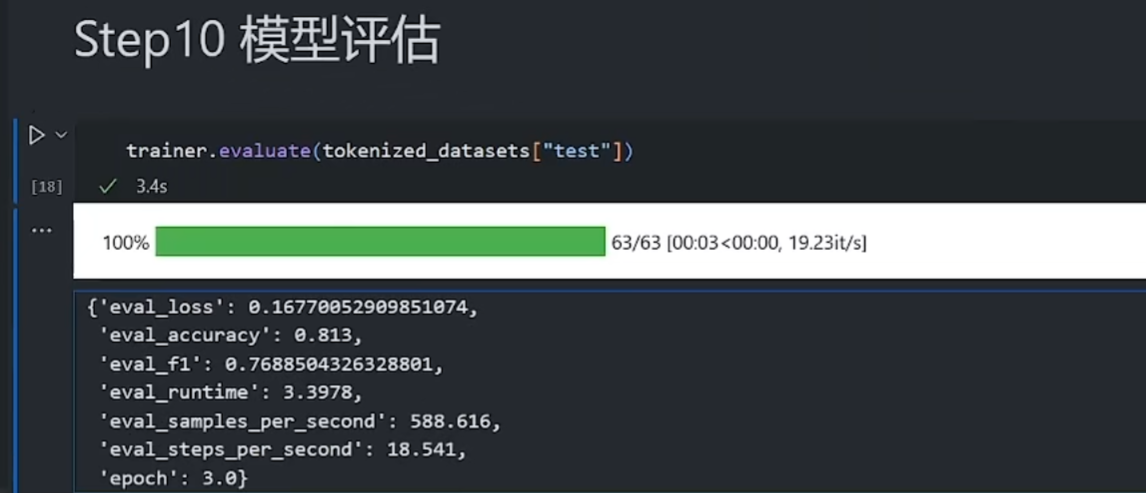

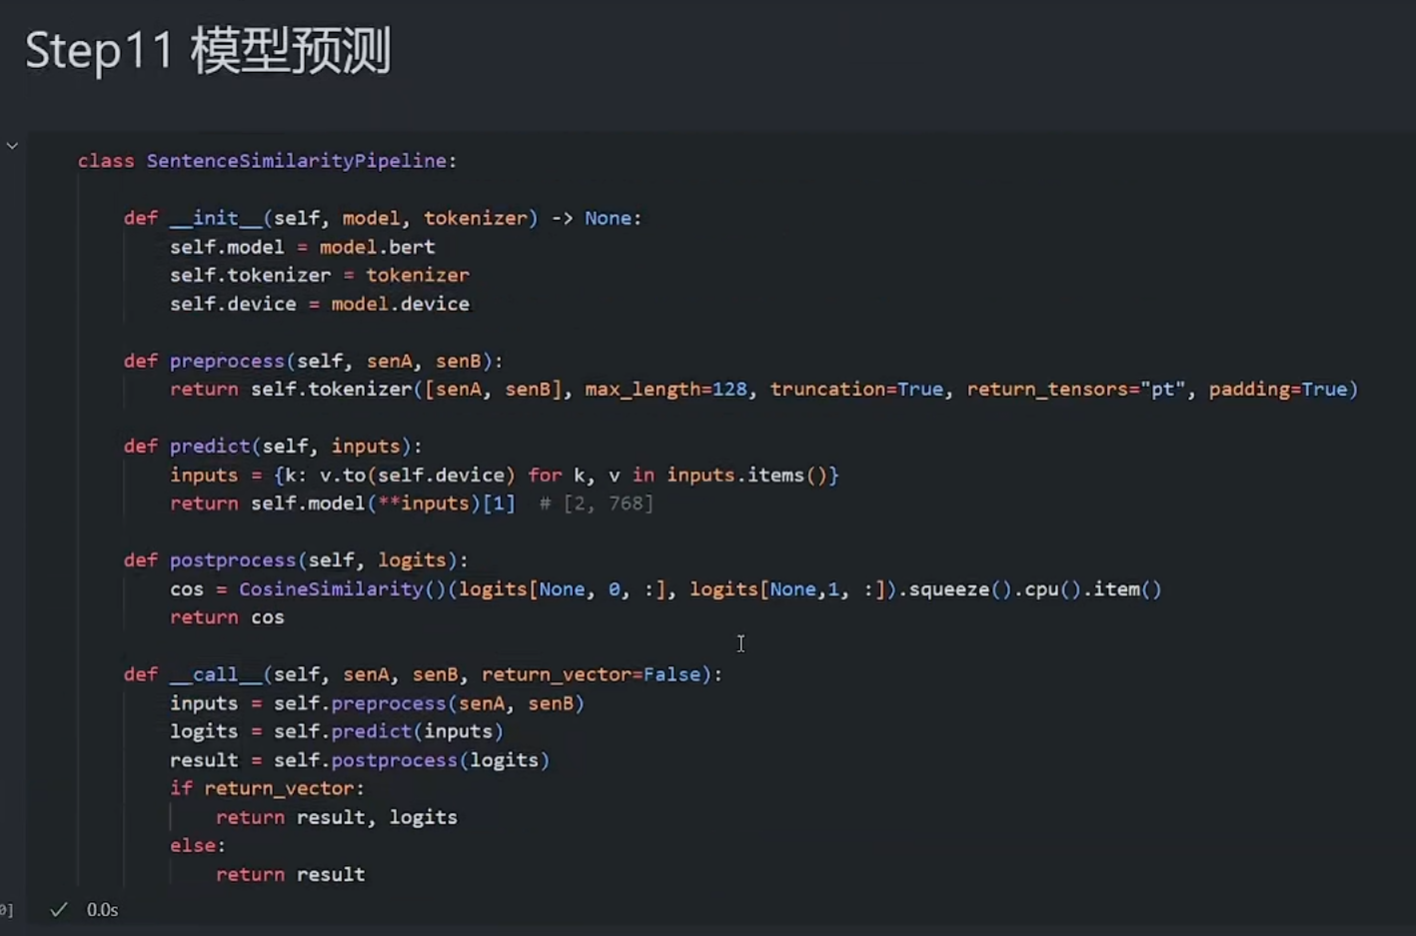

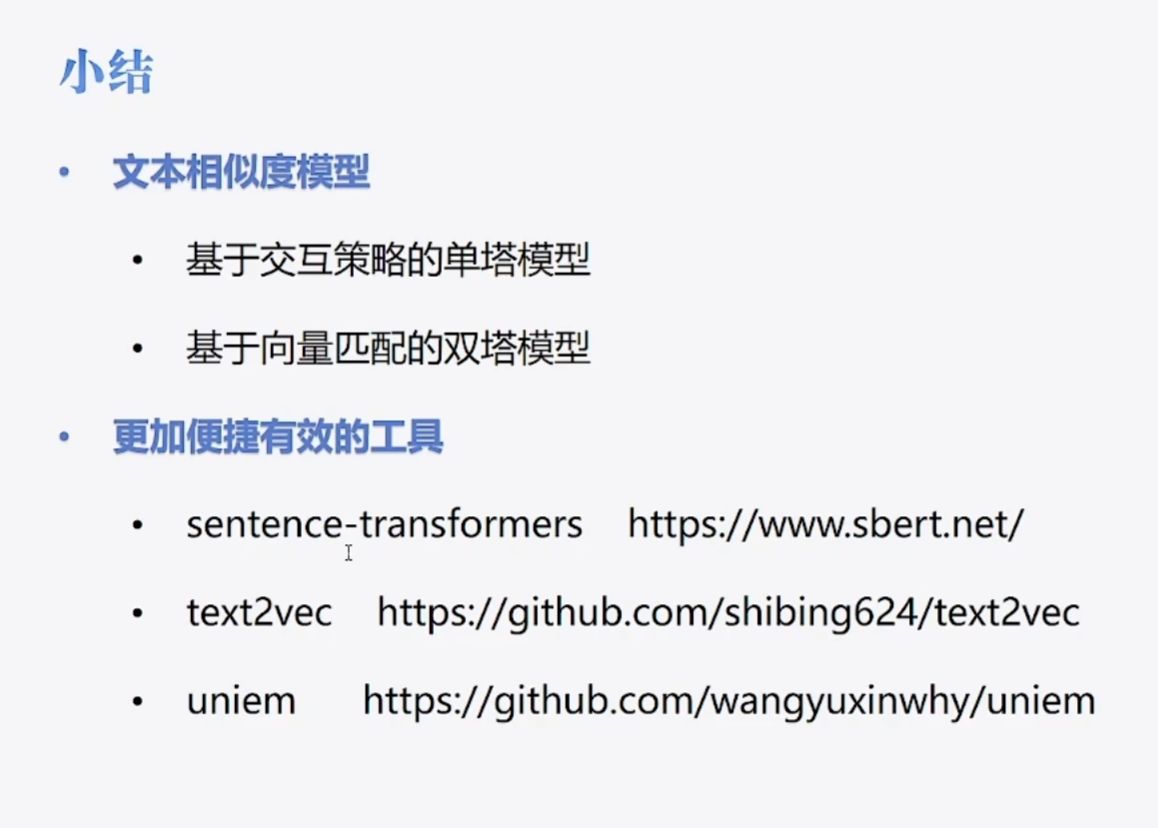